In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/hintont/Dev/packages")

import warnings
warnings.simplefilter("ignore")


In [2]:
import os
import matplotlib.pyplot as plt

import csi.insar as ir
import csi.TriangularPatches as triangleFault
import csi.imagedownsampling as imdown
import csi.imagecovariance as imcov

Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available


In [3]:
name = "ridgecrest"
main = "/Users/hintont/Dev/projects/Ridgecrest"
confdir = os.path.join(main,'config/')
gfsdir = os.path.join(main,'config/gfs/')                      
datadir = os.path.join(main, "data/insar/")
resdir = os.path.join(main,'results/')
figdir = os.path.join(main,'fig/')
faultdir = os.path.join(main,'data/fault/')
lon0= 360-117.5
lat0= 35.7

MINLON, MAXLON, MINLAT, MAXLAT = 360-118.1, 360-117.0 ,35.3, 36.2

In [4]:
faults = []
for igeom in [1,3]:
    fault = triangleFault(f"Fault {igeom}", lon0=lon0, lat0=lat0, utmzone="11")
    fault.readPatchesFromFile(os.path.join(faultdir,f'fault{igeom}.basemesh.triangles'), donotreadslip=True, readpatchindex=False)
    fault.setTrace(delta_depth=0.2)
    fault.discretize(every=0.2, fracstep=0.05)
    fault.xf = fault.xi
    fault.yf = fault.yi
    faults.append(fault)

---------------------------------
---------------------------------
Initializing fault Fault 1
---------------------------------
---------------------------------
Initializing fault Fault 3


In [5]:
subfolder = 'fielding/S1AB/A064/int_0704-0710/'
sarname = 'S1_A064_20190704-0710_v3_unw_m_3asec'
e = 'S1_A064_20190704-0710_v3_east_3asec'
n ='S1_A064_20190704-0710_v3_north_3asec'
u = 'S1_A064_20190704-0710_v3_up_3asec'

sa = ir(sarname, utmzone="11", lon0=lon0, lat0=lat0)
sa.read_from_grd( datadir+subfolder+sarname+'.grd', 
                 los=[ datadir+subfolder+e+'.grd', 
                      datadir+subfolder+n+'.grd', 
                      datadir+subfolder+u+'.grd' ], factor=1.)

# Crop to a given area
sa.select_pixels(MINLON, MAXLON, MINLAT, MAXLAT)
sa.checkNaNs()

---------------------------------
---------------------------------
Initialize InSAR data set S1_A064_20190704-0710_v3_unw_m_3asec
Read from file /Users/hintont/Dev/projects/Ridgecrest/data/insar/fielding/S1AB/A064/int_0704-0710/S1_A064_20190704-0710_v3_unw_m_3asec.grd into data set S1_A064_20190704-0710_v3_unw_m_3asec


In [ ]:
%matplotlib inline

sa.getprofile("a profile", lon0, lat0, 50., 45., 1.)
sa.plotprofile("a profile", fault=faults[0])

In [ ]:
%matplotlib inline

startWindowSize, minimumWindowSize, chardist, expodist, tol = 10., 1.25, 1.5, 0.7, 0.005
threshold, smooth, damping = 0.0035, 7., 0.005

downsampler = imdown('downsampling {}'.format(sa.name), sa, faults)
downsampler.initialstate(startWindowSize, minimumWindowSize, 
                         tolerance=tol, plot=False)
# downsampler.dataBased(threshold, plot=False, quantity='curvature', smooth=smooth)
downsampler.distanceBased(chardist=chardist, expodist=expodist, plot=True)
downsampler.reject_pixels_fault(0.5, faults)
downsampler.writeDownsampled2File(datadir+'{}'.format(sa.name), rsp=True) 

---------------------------------
---------------------------------
Initialize InSAR covariance tools S1_A064_20190704-0710_v3_unw_m_3asec covariance
Masking data set S1_A064_20190704-0710_v3_unw_m_3asec covariance
     Mask: 242.12 <= Lon <= 242.7 || 35.53 <= Lat <= 35.9
Computing covariograms
Computing 1-D empirical semivariogram function for data set S1_A064_20190704-0710_v3_unw_m_3asec covariance
Selecting 5571 random samples to estimate the covariance function
Estimated Orbital Plane: 4.688559887537129e-06xy + -0.019575377820038858x + -0.0014313356001919581y + 5.958511236659851
Build the permutations
Digitize the histogram
Fitting Covariance functions
Dataset S1_A064_20190704-0710_v3_unw_m_3asec covariance:
A prior values: Sill | Sigma | Lambda
                 0.000607 | 0.007372 | 18.613149
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5711789209314032e-05
            Iterations: 16
            Function evaluations: 89
            Gr

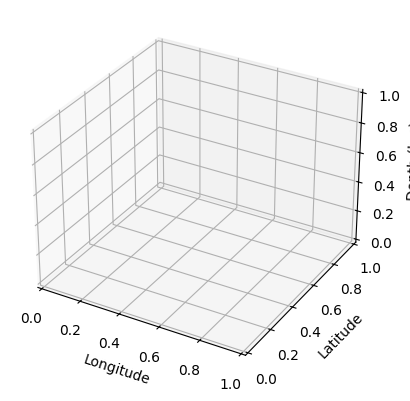

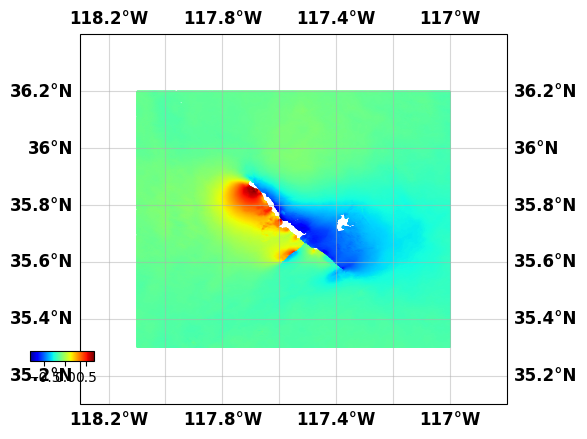

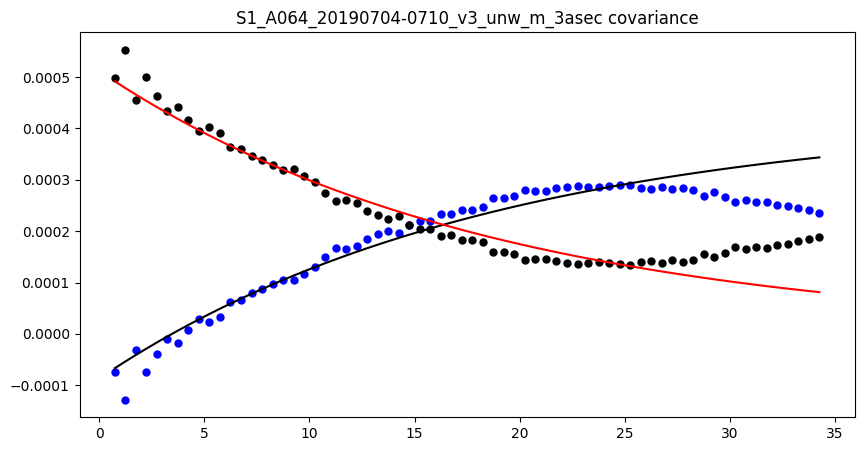

writing covariance output for S1_A064_20190704-0710_v3_unw_m_3asec covariance


In [6]:
#Create a covariance estimation object
covar1 = imcov(sarname+' covariance', sa, verbose=True)
covar1.selectedZones = []
covar1.maskOut([ 360-117.88,360-117.3,35.53,35.9])
#covar1.computeCovariance(function='gauss', frac=0.005, every=1.0, distmax=40.,tol=1e-10)
covar1.computeCovariance(function='exp', frac=0.005, every=0.5, distmax=35.,tol=1e-10)
# Plot
covar1.plot(data='all', plotData=True,savefig=True,savedir=datadir)
# Write to a file
covar1.write2file(savedir=datadir)

---------------------------------
---------------------------------
Initialize InSAR data set S1_A064_20190704-0710_v3_unw_m_3asec
Read from file /Users/hintont/Dev/projects/Ridgecrest/data/insar/S1_A064_20190704-0710_v3_unw_m_3asec into data set S1_A064_20190704-0710_v3_unw_m_3asec


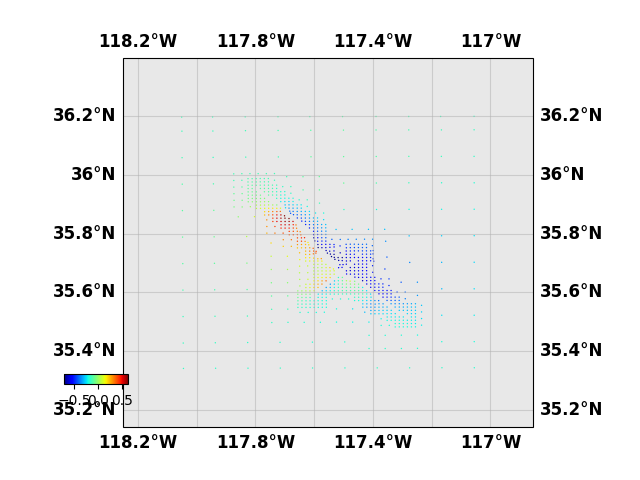

In [7]:
%matplotlib widget
sa = ir(sarname, utmzone="11", lon0=lon0, lat0=lat0)
sa.read_from_varres( datadir+'{}'.format(sarname))
sa.buildCd(0.027436557793776566, 32.21656668629711, function='exp')
sa.plot()

In [8]:
datasets = [sa]
for fault in faults:
    fault.initializeslip()
    for data in datasets:
        fault.buildGFs(data, slipdir="sd")
    fault.assembleGFs(datasets, slipdir="sd", polys=None)
    fault.saveGFs(outputDir=(resdir + "greens"))

Greens functions computation method: Meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
S1_A064_20190704-0710_v3_unw_m_3asec of type insar in a homogeneous half-space
 Patch: 468 / 4736 

KeyboardInterrupt: 

In [9]:
for fault in faults:
    fault.initializeslip()
    for data in datasets:
        sname = os.path.join(resdir+"greens",'{}_{}_SS.gf'.format(fault.name.replace(' ','_'), data.name.replace(' ','_')))
        dname = os.path.join(resdir+"greens",'{}_{}_DS.gf'.format(fault.name.replace(' ','_'), data.name.replace(' ','_')))
        fault.setGFsFromFile(data, strikeslip=sname, dipslip=dname, vertical=True)
    
    fault.assembleGFs(datasets, slipdir='sd')
    fault.assembleCd(datasets)
    fault.assembled(datasets)

---------------------------------
---------------------------------
Set up Green's functions for fault Fault 1
and data S1_A064_20190704-0710_v3_unw_m_3asec from files: 
     strike slip: /Users/hintont/Dev/projects/Ridgecrest/results/greens/Fault_1_S1_A064_20190704-0710_v3_unw_m_3asec_SS.gf
     dip slip:    /Users/hintont/Dev/projects/Ridgecrest/results/greens/Fault_1_S1_A064_20190704-0710_v3_unw_m_3asec_DS.gf
     tensile:     None
     coupling:    None
---------------------------------
---------------------------------
Assembling G for fault Fault 1
Dealing with S1_A064_20190704-0710_v3_unw_m_3asec of type insar
---------------------------------
---------------------------------
Assembling d vector
Dealing with data S1_A064_20190704-0710_v3_unw_m_3asec
---------------------------------
---------------------------------
Set up Green's functions for fault Fault 3
and data S1_A064_20190704-0710_v3_unw_m_3asec from files: 
     strike slip: /Users/hintont/Dev/projects/Ridgecrest/resul

In [10]:
import csi.multifaultsolve as multiflt
import csi.transformation as transformation
import numpy as np

trans = transformation('Orbits and reference frame', utmzone="11", lon0=lon0, lat0=lat0)
trans.buildGFs(datasets, [3]*len(datasets))
trans.assembleGFs(datasets)
trans.assembled(datasets)
trans.assembleCd(datasets)

slv = multiflt(name, faults+[trans])
slv.assembleGFs()
for fault in faults:
   fault.buildCm(1., 1.)
trans.buildCm(1000.)
slv.assembleCm()



#slv.Cd /= 10.
#slv.G *= 100.
bounds = []
for f in range(len(faults)):
   for i in range(faults[f].N_slip):
       bounds.append([0,10.])
   for i in range(faults[f].N_slip):
       bounds.append([-3., 3.])   
for i in range(trans.TransformationParameters):
   bounds.append([-100., 100.])
mprior = np.zeros((len(bounds),))

slv.ConstrainedLeastSquareSoln(bounds=bounds, 
                              iterations=10,
                              method='L-BFGS-B',
                              mprior=mprior, 
                              tolerance=1e-4, 
                              maxfun=100, 
                              checkIter=True)
# slv.distributem()
# trans.removePredictions(datasets)

---------------------------------
---------------------------------
Initializing transformation Orbits and reference frame
---------------------------------
---------------------------------
Assembling G for transformation Orbits and reference frame
---------------------------------
---------------------------------
Assembling d vector
Dealing with data S1_A064_20190704-0710_v3_unw_m_3asec
---------------------------------
---------------------------------
Initializing solver object
Not a fault detected
Number of data: 766
Number of parameters: 12547
Parameter Description ----------------------------------
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Fault 1                       ||   0 - 4736 ||4736 - 9472 ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Fault 3                       ||9472 - 11008||1

In [11]:
slv.distributem()
trans.removePredictions(datasets)

normalizing factors are  449.9561528575439 3953.6623760362327 45.071346901434254 52.65999714690861


In [12]:
import pickle
with open(datadir + sarname + "_mpost.pickle", 'wb') as f:
    pickle.dump(slv.mpost, f)

Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco plotting impossible
HDF5 capabilities not available
Cannot import netCDF4, Gebco

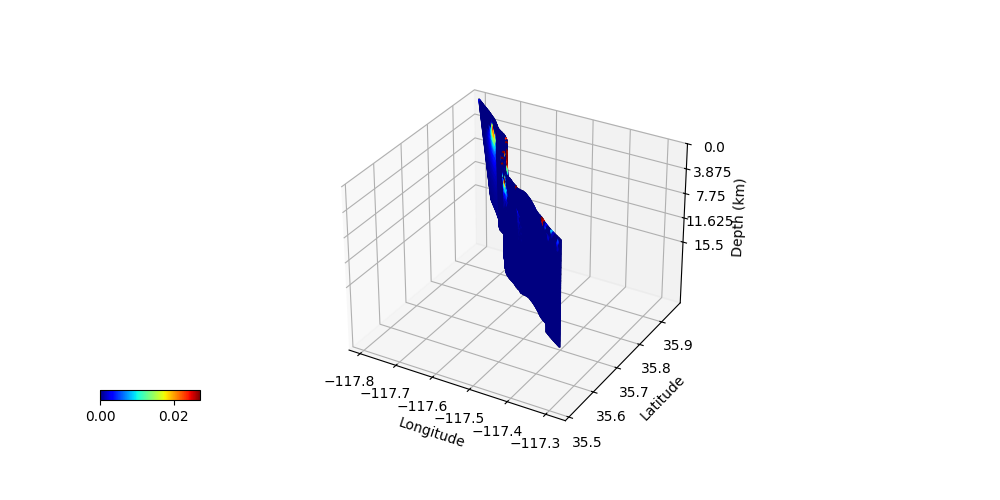

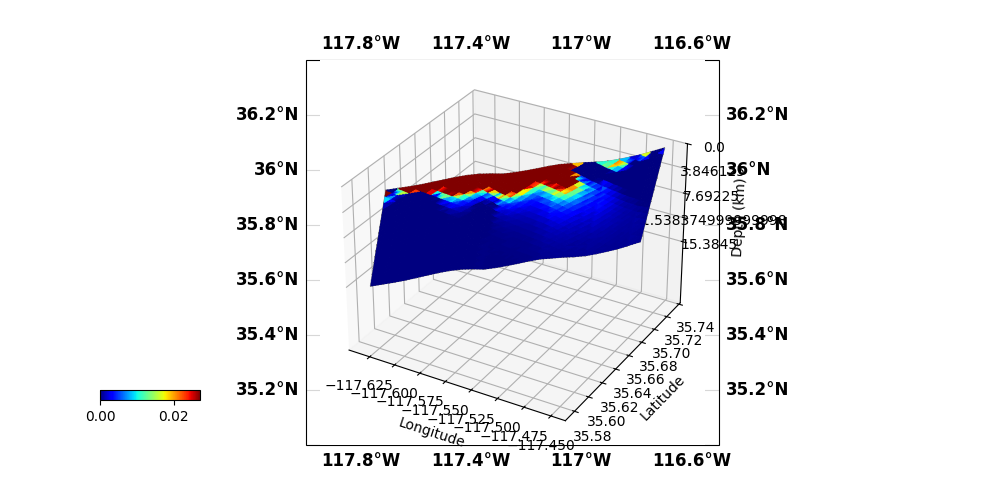

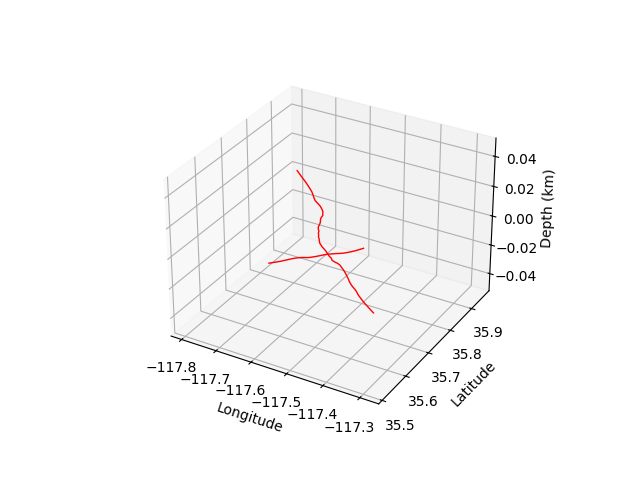

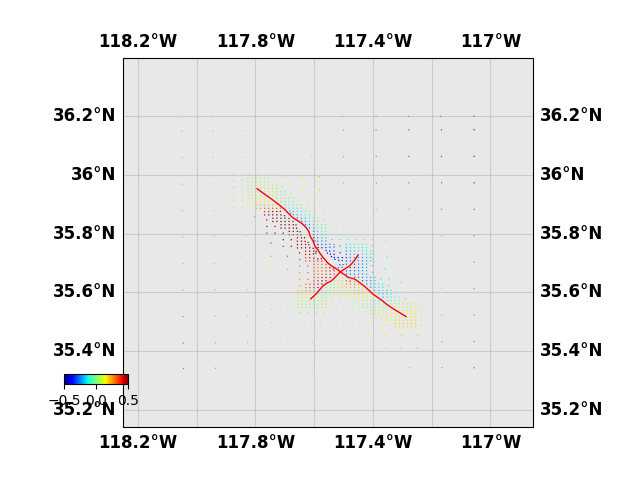

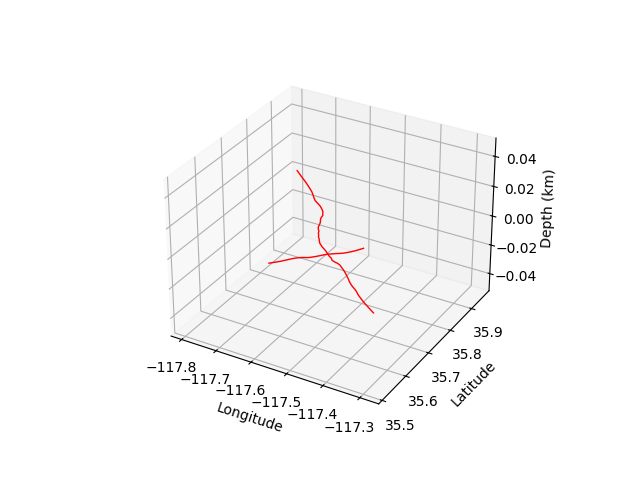

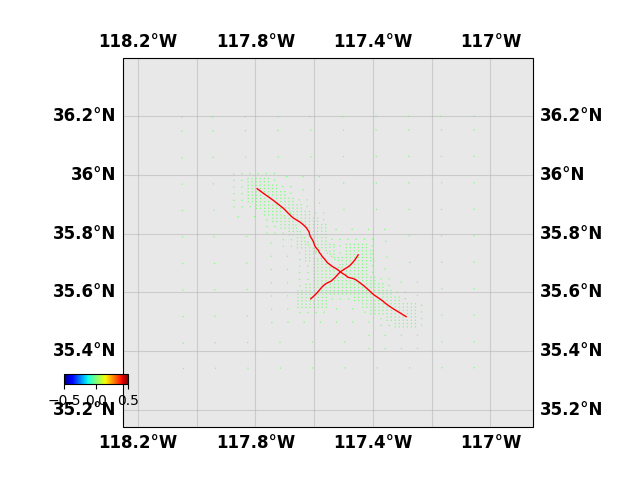

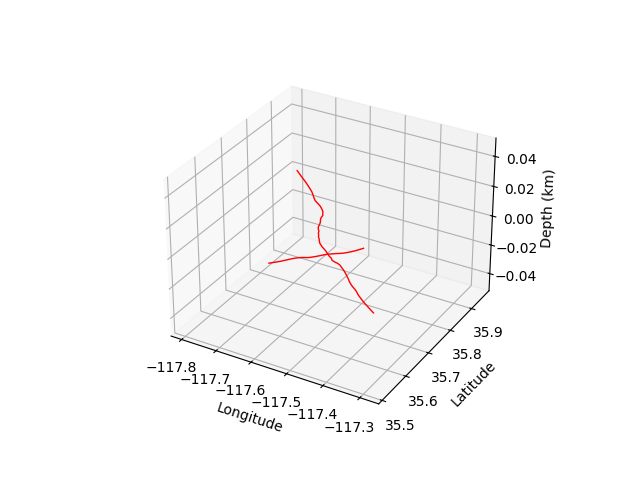

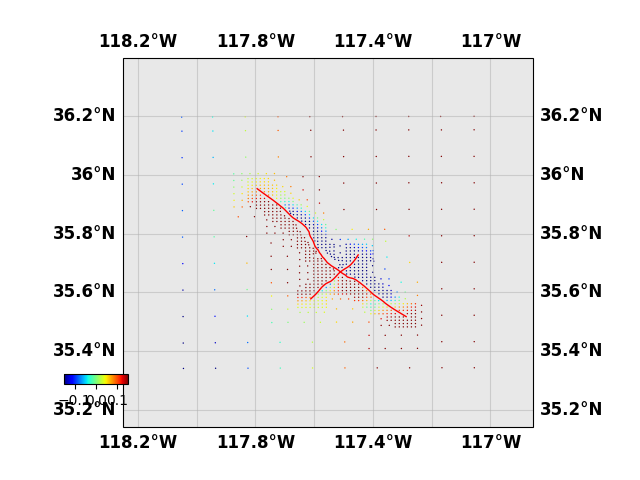

In [13]:
import csi.geodeticplot as geoplt

# Plot predictions and inferred slip
for data in datasets:
   data.buildsynth(slv.faults)

for f in range(len(faults)):
   gp = geoplt(figure=f, lonmin=-118., lonmax=-116.5, latmin=35., latmax=36.4,
           figsize=[(10,5),(10,5)])
   #gp.drawCoastlines(drawLand=True, parallels=0.2, meridians=0.2, drawOnFault=True)
   #gp.faulttrace(faults[0], color='r')
   gp.faultTents(faults[f], colorbar=True, slip='strikeslip', plot_on_2d=False,
                            revmap=False, method='scatter')
   #gp.faultTents(faults[1], colorbar=True, slip='strikeslip', plot_on_2d=False,
   #                         revmap=False, method='scatter')
   #gp.gps(gpsData[0], data=['data', 'synth'], color=['r', 'b'], scale=1., legendscale=0.1)
#    gp = geoplt(figure=2*f, lonmin=-118., lonmax=-116.5, latmin=35., latmax=36.4,
#            figsize=[(10,5),(10,5)])
#    #gp.drawCoastlines(drawLand=True, parallels=0.2, meridians=0.2, drawOnFault=True)
#    #gp.faulttrace(faults[0], color='r')
#    #gp.faultTents(faults[0], colorbar=True, slip='dipslip', plot_on_2d=False,
#    #                         revmap=False, method='scatter')
#    gp.faultTents(faults[1], colorbar=True, slip='strikeslip', plot_on_2d=False,
#                             revmap=False, method='scatter')
for sar in datasets:
   sar.plot(faults=faults, data='data', norm=[-0.5, 0.5], show=False)
   sar.plot(faults=faults, data='synth', norm=[-0.5, 0.5], show=False)
   sar.plot(faults=faults, data='res', norm=[-0.15, 0.15], show=False)